In [2]:
pip install silence_tensorflow

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.3-py3-none-any.whl size=6776 sha256=c425da8e4c533ebd102e8818585eece2d0857f5e62904f5f11490ed4331403c5
  Stored in directory: c:\users\safa\appdata\local\pip\cache\wheels\01\0a\11\47a90c4f9a670979117a7f375c9f9ba5b807d135310bd4c718
Successfully built silence_tensorflow
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'silence_tensorflow' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'silence_tensorflow'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [3]:
# A function to avoid tensorflow warnings
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [4]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('/kaggle/input/fundus-dataset/dataset.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/fundus-dataset/dataset.csv'

In [47]:
df

,image_path,class,label_encoded
0,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
1,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
2,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
3,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
4,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
...,...,...,...
4507,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4508,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4509,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4510,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5


In [48]:
df['label']=df['class']

In [49]:
from sklearn.model_selection import train_test_split
# Separate in train and test data
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

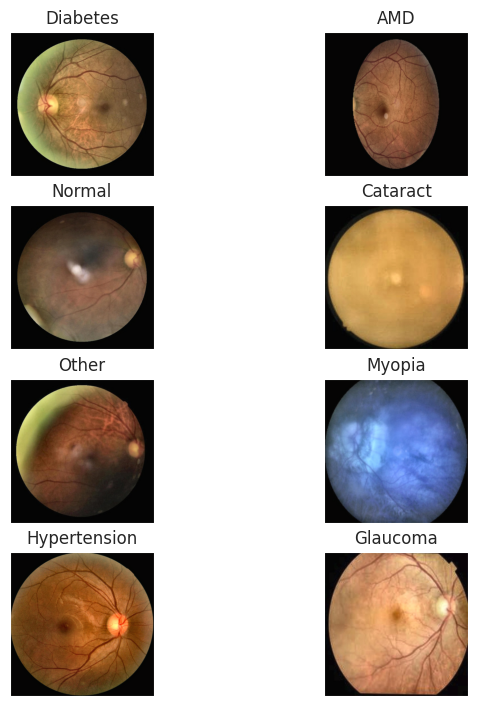

In [50]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.image_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [51]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    zoom_range=0.1,                 # Zoom in and out images by 10%
    horizontal_flip=True,           # Allow horizontal flipping
    shear_range=0.1,                # shear images by 10% their size
    fill_mode='nearest',            # fill unlocated pixels by nearest pixel
    validation_split=0.2
)


In [52]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='image_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,                  
    shuffle=True,
    seed=42,
    
)

# validation generator


validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Change to 'binary' if you have a binary classification problem
    subset='validation'
)
# Test generator

test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 3609 validated image filenames belonging to 8 classes.
Found 721 validated image filenames belonging to 8 classes.
Found 903 validated image filenames belonging to 8 classes.


In [53]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),            # Input image size
    include_top=False,                    # model not include top layer
    weights='imagenet',                   # weights type
    pooling='avg'                         # type of pooling layer
)

In [54]:
# Freeze all layers, except last layer
# The goal is to train just last layer of pre trained model

pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

In [55]:
# Add custom layers on top of the base model
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

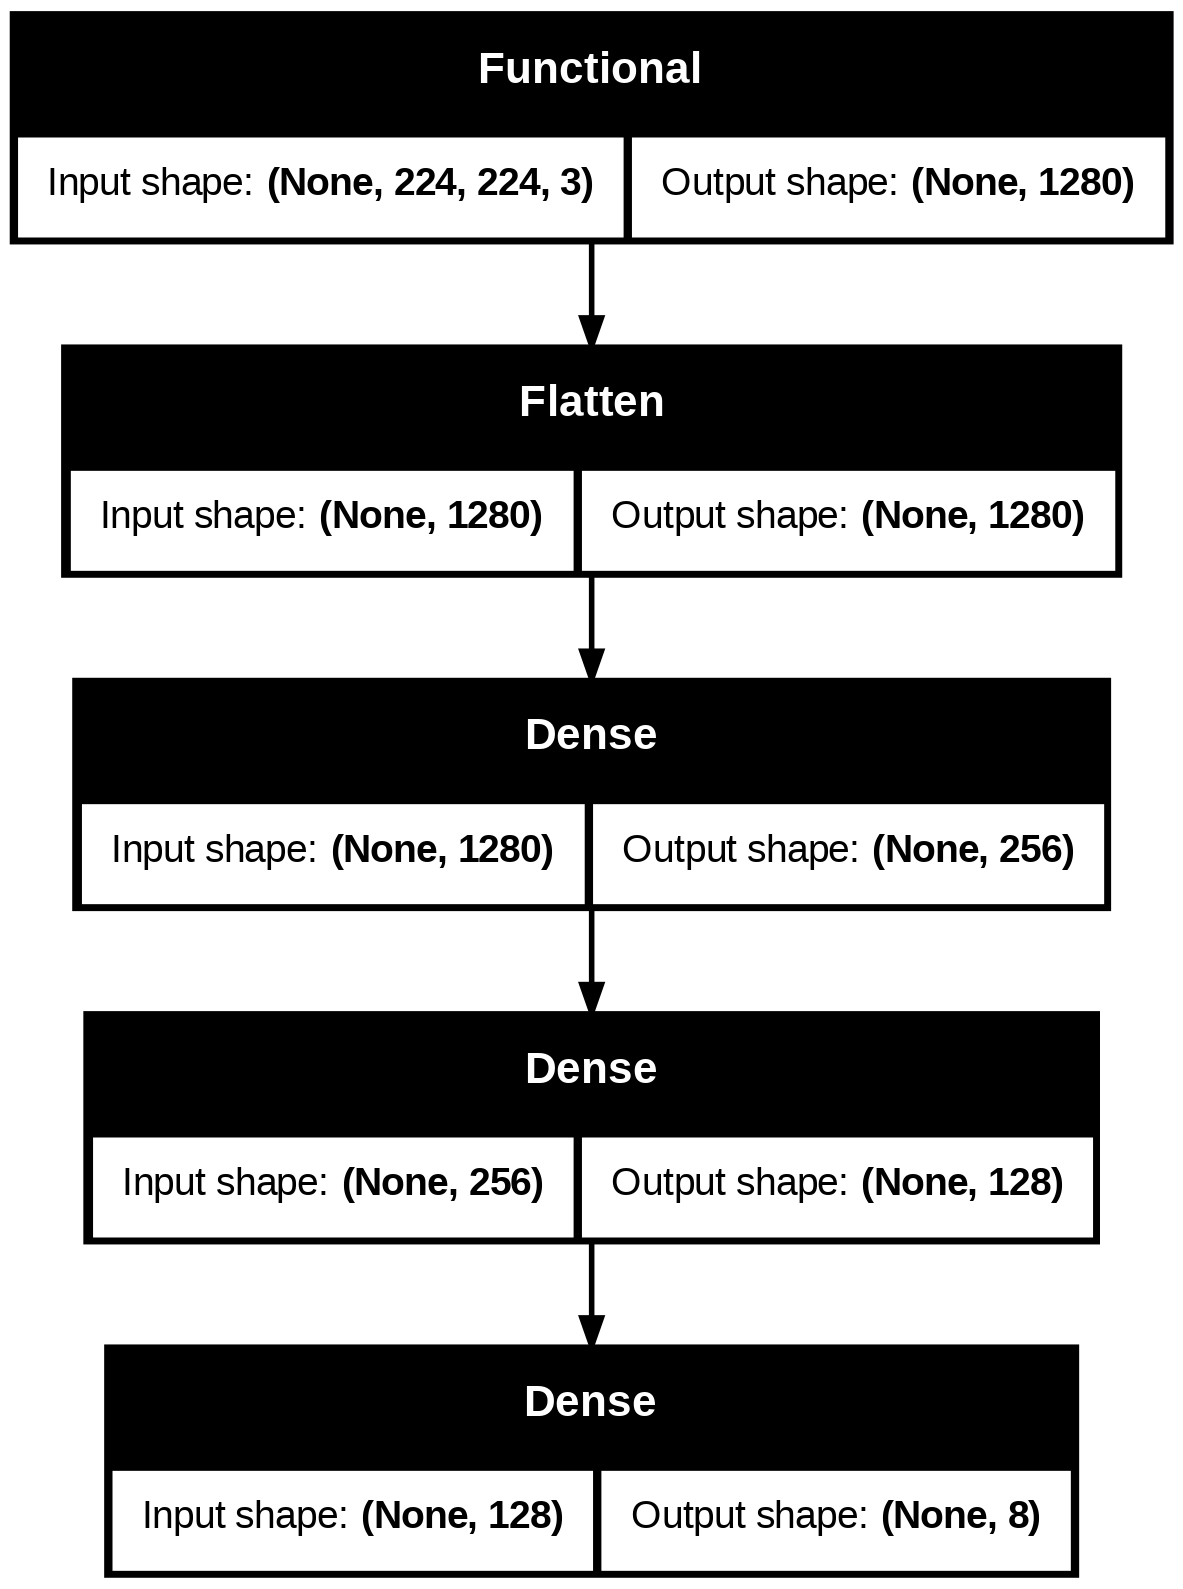

In [56]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [57]:
# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,619,848 (9.99 MB)

 Trainable params: 1,247,944 (4.76 MB)

 Non-trainable params: 1,371,904 (5.23 MB)

In [58]:
# Compile 
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy', 
             metrics=['accuracy'])

In [59]:
# # # Model CheckPoint
# # checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True) 

# # # Early Stoping
# # earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


# # ReduceLROnPlateau
# # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [60]:
# history = model.fit(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     epochs=100,
#     validation_data=validation_generator,
#     validation_steps=len(validation_generator),
#     callbacks=[model_checkpoint, early_stopping, reduce_lr]
# )

In [8]:
import os
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

NUM_CLASSES = 8  # AMD, Cataract, Diabetes, Glaucoma, Hypertension, Myopia, Normal, Other

# ===== 1: Rebuild MobileNetV2 base =====
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights=None,                # IMPORTANT: we will load YOUR weights
    input_shape=(224, 224, 3),
    pooling='avg'                # Output shape = (None, 1280)
)

# ===== 2: Rebuild classifier head =====
x = layers.Flatten(name="flatten")(base_model.output)
x = layers.Dense(256, activation='relu', name="dense")(x)
x = layers.Dense(128, activation='relu', name="dense_1")(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax', name="dense_2")(x)

# ===== 3: Build final model =====
model = models.Model(inputs=base_model.input, outputs=outputs)

# ===== 4: Load your saved weights =====
model = tf.keras.models.load_model("./MobileNetV2_custom.h5")
print("Loaded full model successfully!")
model.summary()


AttributeError: Exception encountered when calling Flatten.call().

[1m'list' object has no attribute 'shape'[0m

Arguments received by Flatten.call():
  • args=(['<KerasTensor shape=(None, 1280), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1436>'],)
  • kwargs=<class 'inspect._empty'>

In [158]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def compute_gradcam(model, img_array, last_conv_layer_name="block_16_project"):
    """
    Grad-CAM for your MobileNetV2 fundus model.
    img_array: shape (1, 224, 224, 3), normalized to [0, 1]
    """
    # Last conv layer in *this* model
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # Model: input -> (conv feature maps, predictions)
    grad_model = tf.keras.Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(img_array, training=False)
        pred_index = tf.argmax(preds[0])
        pred_score = preds[:, pred_index]

    # Gradients of predicted class wrt conv feature maps
    grads = tape.gradient(pred_score, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0].numpy()        # (H, W, C)
    pooled_grads = pooled_grads.numpy()         # (C,)

    # Weight channels by importance
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    # Build heatmap
    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)            # ReLU
    heatmap /= (np.max(heatmap) + 1e-10)        # normalize to [0,1]

    return heatmap  # (H, W)


In [159]:
def show_gradcam_overlay(img_path, heatmap, alpha=0.4):
    """
    Show Grad-CAM overlay on top of the original image.
    """
    # Load original image
    img = Image.open(img_path).convert("RGB").resize((224, 224))
    img_np = np.array(img)

    # Resize heatmap to 224x224
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_resized = Image.fromarray(heatmap_uint8).resize((224, 224))
    heatmap_resized = np.array(heatmap_resized)

    # Apply colormap
    cmap = plt.cm.jet(heatmap_resized / 255.0)[..., :3] * 255
    cmap = cmap.astype(np.uint8)

    # Blend heatmap with original
    overlay = (alpha * cmap + (1 - alpha) * img_np).astype(np.uint8)

    # Show
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.title("Grad-CAM Overlay")
    plt.axis("off")
    plt.show()


In [160]:
from tensorflow.keras.preprocessing import image
import json

def infer_single_image_with_gradcam(model, img_path, class_labels,
                                    last_conv_layer_name="block_16_project"):
    # 1) Load + preprocess
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # 2) Forward pass (prediction)
    preds = model.predict(img_array, verbose=0)[0]
    pred_idx = int(np.argmax(preds))
    pred_label = class_labels[pred_idx]
    pred_score = float(preds[pred_idx])

    # 3) Grad-CAM
    heatmap = compute_gradcam(model, img_array, last_conv_layer_name)

    # 4) Show Grad-CAM overlay
    show_gradcam_overlay(img_path, heatmap)

    # 5) Show probability chart
    show_prediction_chart(preds, class_labels)

    # 6) Build JSON result (no saved images, just info)
    result_json = {
        "input_image": img_path,
        "prediction": {
            "label": pred_label,
            "score": pred_score,
            "class_probabilities": {
                class_labels[i]: float(preds[i]) for i in range(len(class_labels))
            },
        }
    }

    return result_json



🔍 Image: /kaggle/input/fundus-dataset/Fundus Dataset/Fundus Dataset/Normal/139_left.jpg


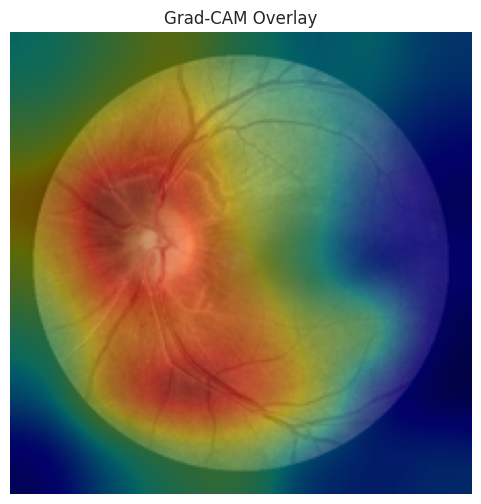

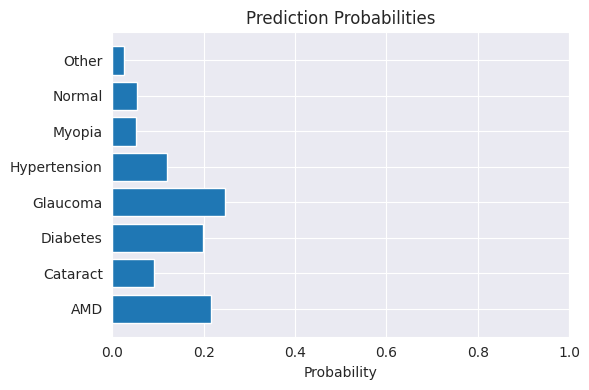

{
  "input_image": "/kaggle/input/fundus-dataset/Fundus Dataset/Fundus Dataset/Normal/139_left.jpg",
  "prediction": {
    "label": "Glaucoma",
    "score": 0.24713744223117828,
    "class_probabilities": {
      "AMD": 0.21507234871387482,
      "Cataract": 0.09017401933670044,
      "Diabetes": 0.19875219464302063,
      "Glaucoma": 0.24713744223117828,
      "Hypertension": 0.11838295310735703,
      "Myopia": 0.052014824002981186,
      "Normal": 0.05283598601818085,
      "Other": 0.02563018538057804
    }
  }
}
--------------------------------------------------------------------------------

🔍 Image: /kaggle/input/fundus-dataset/Fundus Dataset/Fundus Dataset/Myopia/85_left.jpg


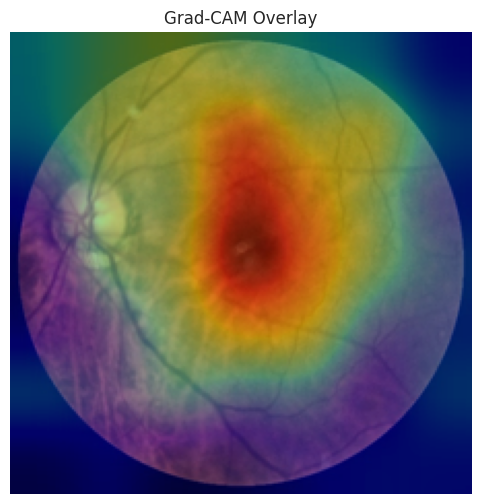

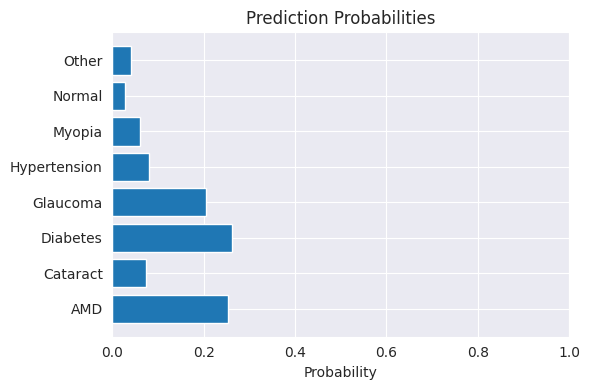

{
  "input_image": "/kaggle/input/fundus-dataset/Fundus Dataset/Fundus Dataset/Myopia/85_left.jpg",
  "prediction": {
    "label": "Diabetes",
    "score": 0.26075759530067444,
    "class_probabilities": {
      "AMD": 0.2520117461681366,
      "Cataract": 0.0741991400718689,
      "Diabetes": 0.26075759530067444,
      "Glaucoma": 0.20416629314422607,
      "Hypertension": 0.08029453456401825,
      "Myopia": 0.06043628975749016,
      "Normal": 0.027018096297979355,
      "Other": 0.04111628234386444
    }
  }
}
--------------------------------------------------------------------------------

🔍 Image: /kaggle/input/fundus-dataset/Fundus Dataset/Fundus Dataset/Glaucoma/Glaucoma1079.jpg


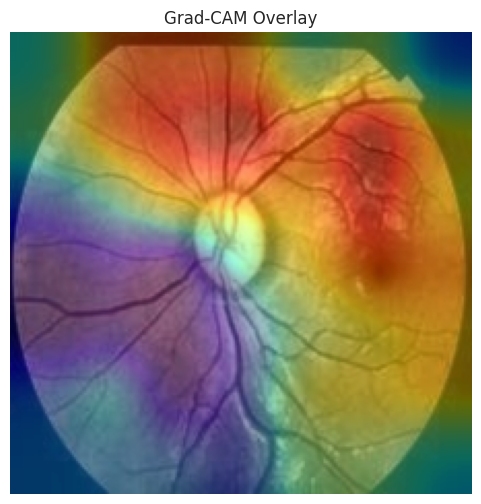

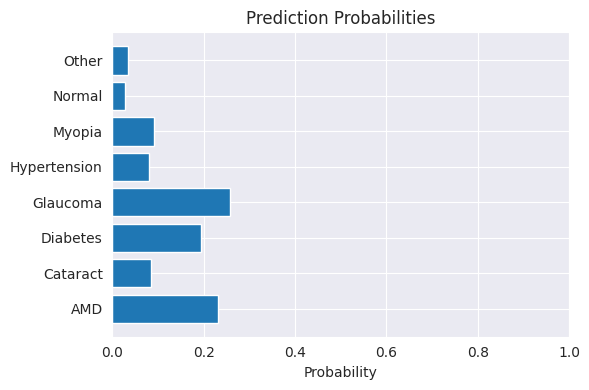

{
  "input_image": "/kaggle/input/fundus-dataset/Fundus Dataset/Fundus Dataset/Glaucoma/Glaucoma1079.jpg",
  "prediction": {
    "label": "Glaucoma",
    "score": 0.2571689188480377,
    "class_probabilities": {
      "AMD": 0.23218898475170135,
      "Cataract": 0.08442451059818268,
      "Diabetes": 0.19304756820201874,
      "Glaucoma": 0.2571689188480377,
      "Hypertension": 0.0789988785982132,
      "Myopia": 0.09108953177928925,
      "Normal": 0.028322968631982803,
      "Other": 0.03475864976644516
    }
  }
}
--------------------------------------------------------------------------------


In [161]:
import random

class_labels = list(test_generator.class_indices.keys())

# pick 3 random test images
sample_paths = random.sample(list(test_df["image_path"]), 3)

results = []

for img_path in sample_paths:
    print(f"\n🔍 Image: {img_path}")
    result = infer_single_image_with_gradcam(model, img_path, class_labels)
    print(json.dumps(result, indent=2))
    print("-" * 80)
    results.append(result)
